# Mode Solver

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FModeSolver.ipynb).

This tutorial shows how to use the mode solver plugin in tidy3d.

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
from tidy3d.constants import C_0
import tidy3d.web as web

from tidy3d.plugins import ModeSolver

## Setup

We first set up the mode solver with information about our system. We start by setting parameters

In [2]:
# size of simulation domain
Lx, Ly, Lz = 6, 6, 6
dl = .05

# waveguide information 
wg_width = 1.5
wg_height = 1.0
wg_permittivity = 4.0

# central frequency 
wvl_um = 2.0
freq0 = C_0 / wvl_um
fwidth = freq0 / 3

# run_time in ps
run_time = 1e-12

Then we set up a simulation, in this case including a straight waveguide

[09:00:17] WARNING  No sources in simulation.                               ]8;id=308476;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=630123;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#365\365]8;;\

<Figure size 432x288 with 1 Axes>

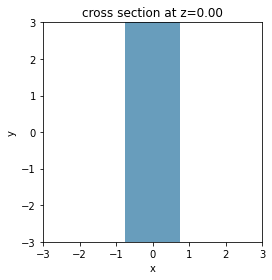

In [3]:
waveguide = td.Structure(
    geometry = td.Box(size=(wg_width, td.inf, wg_height)),
    medium = td.Medium(permittivity=wg_permittivity)
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    pml_layers=(None, None, None),
    structures=[waveguide],
    run_time = run_time,
)

ax = sim.plot(z=0)

## Initialize Mode Solver

With our system defined, we can now create our mode solver. We first need to specify on what plane we want to solve the modes using a `td.Box()` object.

In [4]:
plane = td.Box(
    center=(0,0,0),
    size=(4, 0, 3.5)
)

The mode solver can now compute the modes given a `ModeSpec` object that specifies everything about the modes we're looking for, for example:

- `num_modes`: how many modes to compute.

- `target_neff`: float, default=None, initial guess for the effective index of the mode; if not specified, the modes with the largest real part of the effective index are computed.

The full list of specification parameters can be found [here](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeSpec.html#tidy3d.ModeSpec).

In [5]:
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.0,
)

We can also specify a list of frequencies at which to solvefor the modes.

In [6]:
num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

Finally, we can initialize the `ModeSolver`, and call the solve method.

In [7]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data = mode_solver.solve()

## Visualizing Mode Data

The `mode_info` object contains information about the effective index of the mode and the field profiles, as well as the `mode_spec` that was used in the solver. The effective index data and the field profile data is in the form of xarray DataArrays.

We can for example plot the real part of the effective index for all three modes as follows.

<Figure size 432x288 with 1 Axes>

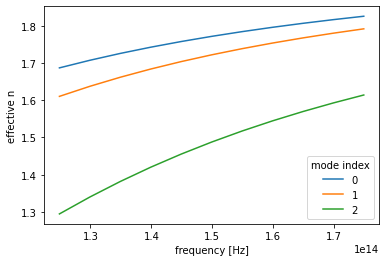

In [8]:
fig, ax = plt.subplots(1)
n_eff = mode_data.n_eff # real part of the effective mode index
n_eff.plot.line(x='f');

The raw data can also be accessed.

In [9]:
n_complex = mode_data.n_complex # complex effective index as a DataArray
n_eff = mode_data.n_eff.values  # real part of the effective index as numpy array
k_eff = mode_data.k_eff.values  # imag part of the effective index as numpy array

print(f'first mode effective index at freq0: n_eff = {n_eff[f0_ind, 0]:.2f}, k_eff = {k_eff[f0_ind, 0]:.2e}')

first mode effective index at freq0: n_eff = 1.77, k_eff = 7.58e-18


The fields stored in `mode_data.fields` can be visualized using in-built xarray methods.

<Figure size 720x216 with 4 Axes>

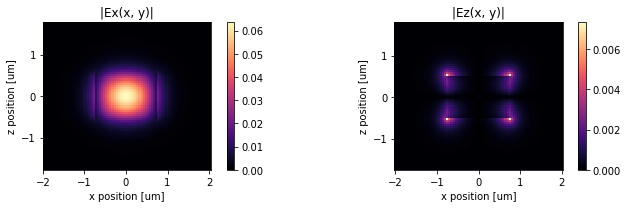

In [10]:
field_data = mode_data.fields

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
abs(field_data.Ex.isel(mode_index=0, f=f0_ind)).plot(x='x', y='z', ax=ax1, cmap="magma")
abs(field_data.Ez.isel(mode_index=0, f=f0_ind)).plot(x='x', y='z', ax=ax2, cmap='magma')

ax1.set_title('|Ex(x, y)|')
ax1.set_aspect("equal")
ax2.set_title('|Ez(x, y)|')
ax2.set_aspect("equal")
plt.show()

Alternatively, we can use the in-built ``plot_field`` method of ``mode_data``, which also allows us to overlay the structures in the simulation. The image also looks slightly different because we have set ``robust=True`` by default, which scales the colorbar to between the 2nd and 98th percentile of the data.

<Figure size 720x216 with 4 Axes>

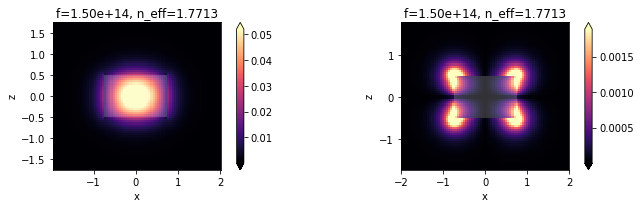

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_data.plot_field("Ex", "abs", mode_index=0, freq=freq0, ax=ax1)
mode_data.plot_field("Ez", "abs", mode_index=0, freq=freq0, ax=ax2)
plt.show()

## Choosing the mode of interest

We can also look at the other modes that were computed.

<Figure size 720x216 with 4 Axes>

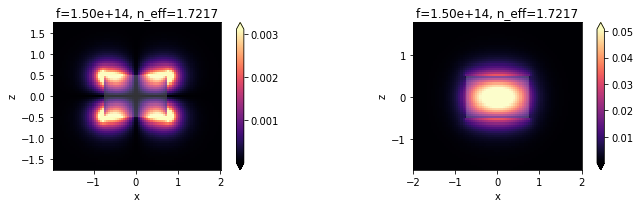

In [12]:
mode_index = 1
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_data.plot_field("Ex", "abs", mode_index=mode_index, freq=freq0, ax=ax1)
mode_data.plot_field("Ez", "abs", mode_index=mode_index, freq=freq0, ax=ax2);
plt.show()

This looks like an Ez-dominant mode. Finally, next-order mode has mixed polarization.

<Figure size 720x216 with 4 Axes>

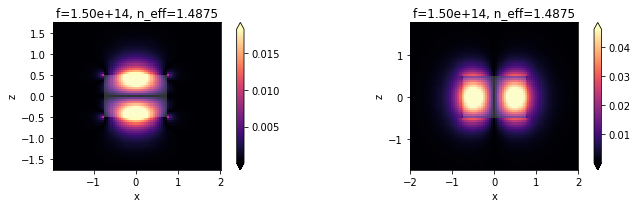

In [13]:
mode_index = 2
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_data.plot_field("Ex", "abs", mode_index=mode_index, freq=freq0, ax=ax1)
mode_data.plot_field("Ez", "abs", mode_index=mode_index, freq=freq0, ax=ax2);
plt.show()

## Exporting Results

This looks promising!

Now we can choose the mode specifications to use in our mode source and mode monitors. These can be created separately, can be exported directly from the mode solver, for example:

In [14]:
# Makes a modal source with geometry of `plane` with modes specified by `mode_spec` and a selected `mode_index`
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_src = mode_solver.to_source(mode_index=2, source_time=source_time, direction='-')

# Makes a mode monitor with geometry of `plane`.
mode_mon = mode_solver.to_monitor(name='mode', freqs=freqs)
# Offset the monitor along the propagation direction
mode_mon.center = (0, -2, 0)

<Figure size 432x288 with 1 Axes>

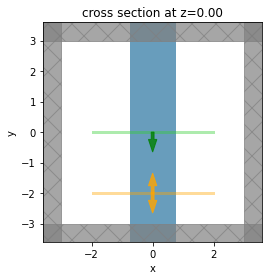

In [15]:
# In-plane field monitor, slightly offset along x
monitor = td.FieldMonitor(
    center=(0, 0, 0.1),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name='field'
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    run_time=run_time,
    pml_layers=(td.PML(), td.PML(), td.PML()),
    structures=[waveguide],
    sources=[mode_src],
    monitors=[monitor, mode_mon]
)

sim.plot(z=0);

In [16]:
job = web.Job(simulation=sim, task_name='mode_simulation')
sim_data = job.run(path='data/simulation_data.hdf5')

[09:00:23] INFO     Using Tidy3D credentials from stored file                      ]8;id=598006;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=838014;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#74\74]8;;\

[09:00:26] INFO     Uploaded task 'mode_simulation' with task_id                ]8;id=240575;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=619398;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '4568a679-4df0-49a4-bf81-1ef18f5707ba'.                                  

[09:00:28] INFO     Maximum flex unit cost: 0.20                                ]8;id=314026;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=298210;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

/usr/local/lib/python3.9/site-packages/rich/live.py:221: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[09:00:39] INFO     status = preprocess                                         ]8;id=349305;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=423467;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[09:00:55] INFO     starting up solver                                          ]8;id=157240;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=449481;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[09:01:14] INFO     running solver                                              ]8;id=566689;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=927690;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

[09:01:18] INFO     early shutoff detected, exiting.                            ]8;id=34203;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=892323;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

[09:01:21] INFO     status = postprocess                                        ]8;id=86864;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=658027;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:01:29] INFO     status = success                                            ]8;id=945444;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=884870;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:01:33] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=530921;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=766452;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/simulation_data.hdf5"                                              

[09:01:34] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=803436;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=162747;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

We can now plot the in-plane field and the modal amplitudes. Since we injected mode 2 and we just have a straight waveguide, all the power recorded by the modal monitor is in mode 2, going backwards.

<Figure size 720x288 with 3 Axes>

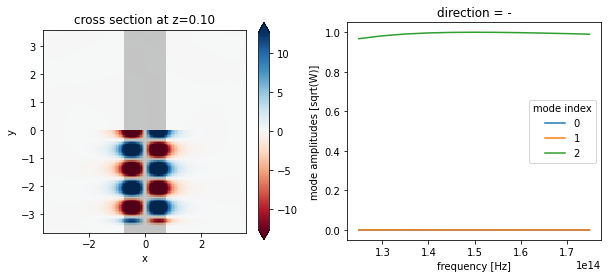

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim_data.plot_field("field", "Ez", freq=freq0, ax=ax[0])
sim_data['mode']['amps'].sel(direction='-').abs.plot.line(x='f', ax=ax[1]);

## Storing server-side computed modes

We can also use a `ModeFieldMonitor` to store the modes as they are computed server-side. This is illustrated below. We will also request in the mode specification that the modes are ordered by their `tm_fraction`. In this particular simulation, this means the modes with largest integrated intensity of their `Ez` component. Similarly we could select `te_fraction` to sort by the `Ex` component in the current example.

In [18]:
mode_spec.sort_by = "tm_fraction"

# Update mode source to use the highest-tm-fraction mode
mode_src.mode_spec = mode_spec
mode_src.mode_index = 0

# Update mode monitor to use the tm_fraction ordered mode_spec
mode_mon.mode_spec = mode_spec

# New monitor to record the modes computed at the mode decomposition monitor location
mode_solver_mon = td.ModeFieldMonitor(
    center=mode_mon.center, 
    size=mode_mon.size,
    freqs=mode_mon.freqs,
    mode_spec=mode_spec,
    name="mode_fields"
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    run_time=run_time,
    pml_layers=(td.PML(), td.PML(), td.PML()),
    structures=[waveguide],
    sources=[mode_src],
    monitors=[monitor, mode_mon, mode_solver_mon]
)

In [19]:
job = web.Job(simulation=sim, task_name='mode_simulation')
sim_data = job.run(path='data/simulation_data.hdf5')

[09:01:37] INFO     Uploaded task 'mode_simulation' with task_id                ]8;id=199566;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=928918;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '4d6f0247-42ff-4efc-aeee-cd0fa886bd0a'.                                  

[09:01:38] INFO     Maximum flex unit cost: 0.20                                ]8;id=716712;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=236489;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

/usr/local/lib/python3.9/site-packages/rich/live.py:221: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[09:01:48] INFO     status = preprocess                                         ]8;id=20102;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=653781;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[09:02:08] INFO     starting up solver                                          ]8;id=894959;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=683323;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[09:02:30] INFO     running solver                                              ]8;id=278377;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=949121;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

[09:02:34] INFO     early shutoff detected, exiting.                            ]8;id=693706;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=380063;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

[09:02:38] INFO     status = postprocess                                        ]8;id=571173;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=617391;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:03:04] INFO     status = success                                            ]8;id=903705;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=601688;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#296\296]8;;\

[09:03:05] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=62422;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=974395;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/simulation_data.hdf5"                                              

[09:03:07] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=164150;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=108901;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

Note the different ordering of the recorded modes compared to what we saw above, which used the default ordering `"largest_neff"`.

<Figure size 432x288 with 1 Axes>

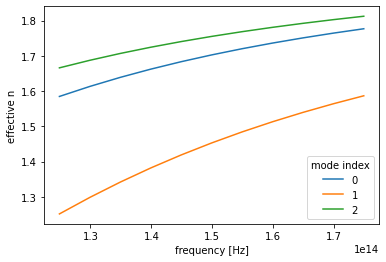

In [20]:
fig, ax = plt.subplots(1)
n_eff = sim_data["mode"].n_eff # real part of the effective mode index
n_eff.plot.line(x='f');

Now the fundamental Ez-polarized mode is injected, and as before it is the only one that the mode monitor records any intensity in.

<Figure size 720x288 with 3 Axes>

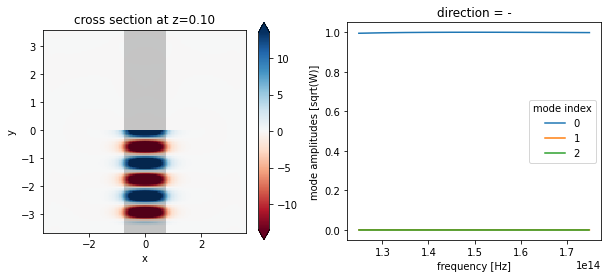

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim_data.plot_field("field", "Ez", freq=freq0, ax=ax[0])
sim_data['mode']['amps'].sel(direction='-').abs.plot.line(x='f', ax=ax[1]);

We can also have a look at the mode fields stored in the `ModeFieldMonitor` either directly using xarray methods as above, or using the Tidy3D `SimulationData` in-built field plotting. Note that here we have to specificall

<Figure size 864x288 with 4 Axes>

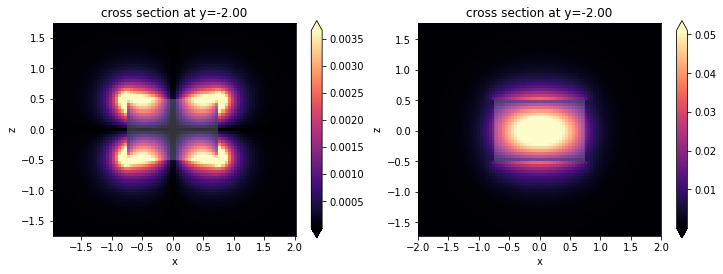

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sim_data.plot_field("mode_fields", "Ex", freq=freq0, val="abs", mode_index=0, ax=ax[0])
sim_data.plot_field("mode_fields", "Ez", freq=freq0, val="abs", mode_index=0, ax=ax[1]);

## Notes / Considerations

- This mode solver runs locally, which means it does not require credits to run.
- It also means that the mode solver does not use subpixel-smoothening, even if this is specified in the simulation. On the other hand, when the modes are stored in a `ModeFieldMonitor` during a simulation run, the subpixel averaging is applied. Therefore, the latter results may not perfectly match those from a local run, and are more accurate.
- Symmetries are applied if they are defined in the simulation and the mode plane center sits on the simulation center.  